In [1]:
BATCH_SIZE = 32
MAX_LEN = 512
EMBEDDING_DIM = 300

In [2]:
import tensorflow as tf

def parse(example):
    features = tf.parse_single_example(
        example,
        features={
            'X': tf.FixedLenFeature([MAX_LEN, EMBEDDING_DIM], dtype=tf.float32),
            'Y': tf.FixedLenFeature((9,), dtype=tf.float32)
        })
    
    X = features['X']
    Y = features['Y']
    
    return X, Y

In [3]:
def iterator(tfrecord_path, data_len):
    dataset = tf.data.TFRecordDataset([tfrecord_path]).map(parse)
    dataset = dataset.repeat(-1).batch(data_len)
    iterator = dataset.make_one_shot_iterator()

    X, Y = iterator.get_next()
    X = tf.reshape(X, [-1, MAX_LEN, EMBEDDING_DIM])
    
    return X, Y

In [4]:
%%time

x_train, y_train = iterator('train.tfrecord', 5893)
x_test, y_test = iterator('test.tfrecord', 1474)

x_train = tf.Session().run(x_train)
y_train = tf.Session().run(y_train)
x_test = tf.Session().run(x_test)
y_test = tf.Session().run(y_test)

CPU times: user 24.6 s, sys: 5.79 s, total: 30.4 s
Wall time: 29.6 s


In [5]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5893, 512, 300), (5893, 9), (1474, 512, 300), (1474, 9))

In [6]:
filters = 256
kernel_size = 3
hidden_dims = 256
epochs = 10

In [7]:
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Conv1D, GlobalMaxPooling1D

model = Sequential()
model.add(Conv1D(filters,
                kernel_size,
                padding='valid',
                activation='relu',
                strides=1,
                input_shape=(MAX_LEN, EMBEDDING_DIM)
                ))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims, 
                activation='relu'
               ))
model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))

model.summary()

Using TensorFlow backend.


Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 510, 256)          230656    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 2313      
Total params: 298,761
Trainable params: 298,761
Non-trainable params: 0
_________________________________________________________________


In [8]:
from keras.optimizers import Adam

model.compile(loss='categorical_crossentropy',
             optimizer=Adam(),
             metrics=['accuracy'])

In [9]:
%%time

hist = model.fit(x_train,
                 y_train,
                batch_size=BATCH_SIZE,
                epochs=epochs,
                validation_data=(x_test, y_test))

Train on 5893 samples, validate on 1474 samples
Epoch 1/10
5893/5893 [==============================] - 4s 696us/step - loss: 0.9756 - acc: 0.6810 - val_loss: 0.4249 - val_acc: 0.8677
Epoch 2/10
5893/5893 [==============================] - 2s 359us/step - loss: 0.3043 - acc: 0.9075 - val_loss: 0.2723 - val_acc: 0.9186
Epoch 3/10
5893/5893 [==============================] - 2s 363us/step - loss: 0.1532 - acc: 0.9540 - val_loss: 0.2157 - val_acc: 0.9362
Epoch 4/10
5893/5893 [==============================] - 2s 361us/step - loss: 0.0890 - acc: 0.9754 - val_loss: 0.1782 - val_acc: 0.9450
Epoch 5/10
5893/5893 [==============================] - 2s 362us/step - loss: 0.0488 - acc: 0.9871 - val_loss: 0.1514 - val_acc: 0.9593
Epoch 6/10
5893/5893 [==============================] - 2s 370us/step - loss: 0.0213 - acc: 0.9946 - val_loss: 0.1497 - val_acc: 0.9607
Epoch 7/10
5893/5893 [==============================] - 2s 377us/step - loss: 0.0153 - acc: 0.9971 - val_loss: 0.1522 - val_acc: 0.9566


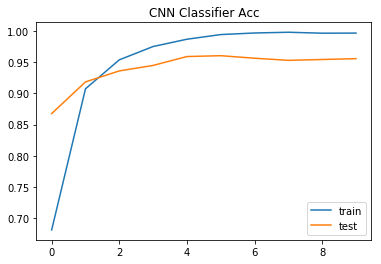

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('CNN Classifier Acc')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

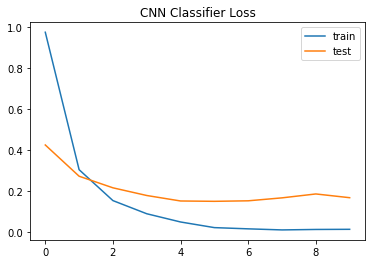

In [11]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('CNN Classifier Loss')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [12]:
import numpy as np

pred_values_orig = model.predict(x_test)
pred_values = np.argmax(pred_values_orig, axis=1)
print('shape of pred_values:', pred_values.shape)
y_test = np.argmax(y_test, axis=1)
print('shape of y_test:', y_test.shape)

shape of pred_values: (1474,)
shape of y_test: (1474,)


In [13]:
from sklearn.metrics import classification_report, confusion_matrix

target_names = ['dokujo-tsushin', 'it-life-hack', 'kaden-channel',\
                'livedoor-homme', 'movie-enter', 'peachy', 'smax',\
                'sports-watch', 'topic-news']

result = classification_report(y_test, pred_values, digits=3, target_names=target_names)

print(result)

                precision    recall  f1-score   support

dokujo-tsushin      0.920     0.920     0.920       175
  it-life-hack      0.962     0.987     0.974       154
 kaden-channel      0.994     0.976     0.985       167
livedoor-homme      0.938     0.798     0.863       114
   movie-enter      0.929     0.983     0.955       174
        peachy      0.929     0.929     0.929       184
          smax      0.968     0.989     0.979       186
  sports-watch      0.982     0.994     0.988       163
    topic-news      0.981     0.981     0.981       157

     micro avg      0.956     0.956     0.956      1474
     macro avg      0.956     0.951     0.953      1474
  weighted avg      0.956     0.956     0.955      1474



Normalized confusion matrix
[[0.92  0.    0.    0.023 0.011 0.04  0.    0.    0.006]
 [0.    0.987 0.    0.    0.006 0.    0.006 0.    0.   ]
 [0.    0.    0.976 0.    0.006 0.012 0.006 0.    0.   ]
 [0.009 0.044 0.009 0.798 0.061 0.026 0.026 0.018 0.009]
 [0.006 0.    0.    0.006 0.983 0.006 0.    0.    0.   ]
 [0.06  0.    0.    0.    0.011 0.929 0.    0.    0.   ]
 [0.    0.005 0.    0.005 0.    0.    0.989 0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.994 0.006]
 [0.006 0.    0.    0.    0.    0.    0.006 0.006 0.981]]


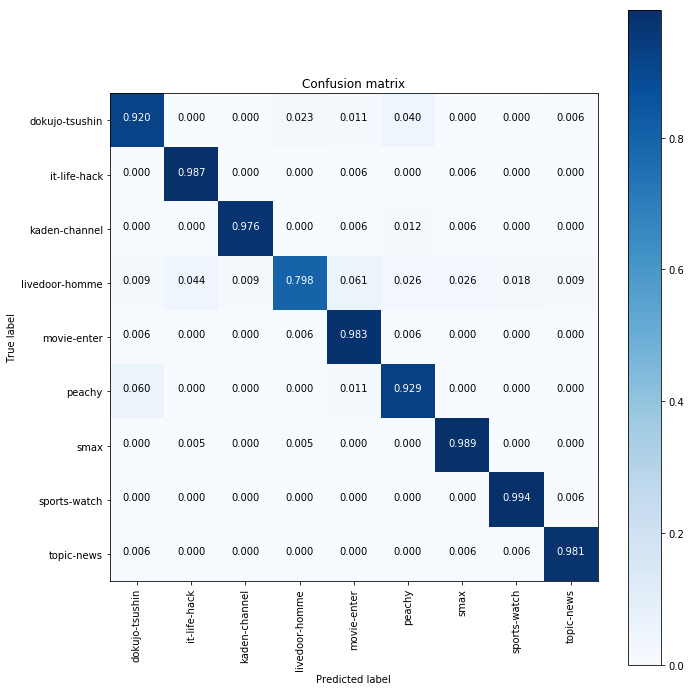

In [14]:
from plot_graph import plot_confusion_matrix
%matplotlib inline
from pylab import rcParams

rcParams['figure.figsize'] = 10,10

conf_mat = confusion_matrix(y_test, pred_values)
plot_confusion_matrix(conf_mat, target_names, normalize=True)